# Esercizio 3 - Sequence tree

#### Helper functions

In [114]:
from datetime import timedelta
import os
from datetime import datetime
import itertools
import random
import math

random.seed(1)


# Takes a timedelta and prints it in a human-readable format.
def format_timedelta(td: timedelta) -> str:
    days = td.days
    years, days = divmod(days, 365)
    months, days = divmod(days, 30)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    formatted_str = ""
    if years:
        formatted_str += f"{years}y "
    if months:
        formatted_str += f"{months}mo "
    if days:
        formatted_str += f"{days}d "
    if hours:
        formatted_str += f"{hours}h "
    if minutes:
        formatted_str += f"{minutes}m "
    if seconds:
        formatted_str += f"{seconds}s "
    

    
    return formatted_str[:-1] if formatted_str else "0s"
  
# Given a set with binary classes, computes entropy
def compute_entropy(dataset_Y):
    ones = len(list(filter(lambda classification : classification == 1,dataset_Y)))
    zeros = len(list(filter(lambda classification : classification == -1,dataset_Y)))

    if(ones == 0 or zeros==0):
        return 0
    
    entropy = ones/len(dataset_Y)*math.log2(1/(ones/len(dataset_Y))) + zeros/len(dataset_Y)*math.log2(1/(zeros/len(dataset_Y)))

    return entropy

# returns a list of tuples (i,x) where i is the index of the patient in the dataset and x is a timedelta of per quanto tempo abbiamo rilevazioni
def find_durations(dataset):
    lengths = []
    for entry in dataset:
        min_t = datetime.max
        max_t = datetime.min
        for item in entry:
            if item[0] < min_t:
                min_t = item[0]
            elif item[0] > max_t:
                max_t = item[0]
        lengths.append(max_t-min_t)
    return [(i, x) for i, x in enumerate(lengths)]

# Find al possible d,l couples that I could split the tree on. Note: Ds are randomly/evenly selected bc otherwise I'd end up with ~36000 pairs...
def create_pairs(dataset_X:list,dataset_ST:list,howmany_d =30,random_sampling=False):

    #1. Create all labels available from current
    labels = set()
    for i in range(0,len(dataset_X)):
        for item in dataset_X[i]:
            if (item[0] > dataset_ST[i]):# Only consider label if it's not been superato
                labels.add(item[1])


    #2. Find all d
    durations = set()
    if random_sampling:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                if (item[0] > dataset_ST[i]): # Only consider timestamp if it's not been superato
                    durations.add(item[0]-dataset_ST[i])
        if len(durations)>howmany_d:
            durations = random.sample(sorted(durations),howmany_d) # Is this ok?
        else:
            durations = sorted(durations)
    else:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                durations.add(item[0]-dataset_ST[i])
        delta = max(durations)/(howmany_d+1)
        durations = set()
        for i in range(1,howmany_d+1):
            durations.add(delta*i)

    return sorted(list(itertools.product(durations,labels)))

# Given a d,l couple, split the dataset and return indexes of true and false entries.
def test_event(dataset_X,dl_pair,dataset_ST):
    i_T = [] # indexes of entries that have label==l within d time
    i_F = [] # indexes of entries that have DON'T HAVE label==l within d time
    d,l = dl_pair


    #1. Separate entries that satisfy event test from those who don't
    for i in range(0,len(dataset_X)):
        entry = dataset_X[i]
        found=False

        for item in entry:
            #print(item)
            if(found is False and item[0]>=dataset_ST[i] and item[0]<=(dataset_ST[i]+d) and item[1]==l ):
                found=True

        if(found):
            i_T.append(i)
        else:
            i_F.append(i)
    return i_T,i_F


#### Loading and parsing DS

In [115]:
def load_diabetes_dataset(verbose=False)-> list: 
    folder_path="datasets\\diabetes"
    dataset = []
    errcount=0
    print(f"-- DS loader")

    for filename in os.listdir(folder_path):

        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path)and filename.startswith('data'):
            entry=[]

            with open(file_path, 'r') as file:
                content = file.readlines()
                for line in content:
                    item = tuple((line[0:-1] if line.endswith('\n') else tuple(line)).split("\t"))

                    # If the item is valid, append it to the entry
                    try:
                        item_f = datetime.strptime(item[0]+" "+item[1], "%m-%d-%Y %H:%M")
                        entry.append((item_f,item[2],item[3]))
                    except:
                        if(verbose):
                            print(f"\t[!] Entry {item} in file {filename} is NOT vallid. Skipped!")
                        errcount+=1
                # add the entry to the dataset
                dataset.append(entry)
    print(f"\tSkipped {errcount} items for formatting issues in data file. {len(dataset)} loaded.")
    return dataset

def compute_datasets(dataset:list,observation_window,waiting_window,prediction_window):

    dataset_X = []
    dataset_Y = []
    
    dataset_ST = [entry[0][0] for entry in dataset ]

    count_excluded=0

    for i in range(0,len(dataset)):
        entry = dataset[i]

        end_obs = dataset_ST[i]+observation_window
        
        start_pred = end_obs + waiting_window
        end_pred = start_pred + prediction_window

        if end_pred < entry[-1][0]:
            entry_X = []
            found = 0

            for item in entry:
                if item[0]>= dataset_ST[i] and item[0]<end_obs:
                    entry_X.append(item)
                if item[0]>=start_pred and item[0]<end_pred:
                    # put Y=1 if it has at least one "65" entry
                    if (item[1]=="65"):
                        found = 1
            dataset_X.append(entry_X)
            dataset_Y.append(found)

        else:
            count_excluded+=1
    
    dataset_ST = [entry[0][0] for entry in dataset_X ]
    dataset_V = [None]*len(dataset_X)
    print(f"-- DS builder")
    print(f"\t{count_excluded} entries unsuitable for selected windows.")
    print(f"\tFinal dataset size: {len(dataset_X)}. Classes: {sum(1 for c in dataset_Y if c == 1)}|{sum(1 for c in dataset_Y if c == 0)}, entropy {float(compute_entropy(dataset_Y)):4.3}")    
    return dataset_X,dataset_Y,dataset_ST,dataset_V

# Quick reload if needed for testing/showcasing purposes
def reload_ds():
    # prepare
    dataset = load_diabetes_dataset(False)
    observation_window = timedelta(days=+3)
    waiting_window = timedelta(days=+0)
    prediction_window = timedelta(days=+10)

    dataset_X,dataset_Y, dataset_ST,dataset_V = compute_datasets(dataset,observation_window,waiting_window,prediction_window,)
    return dataset_X[:-1],dataset_Y[:-1], dataset_ST[:-1],dataset_V[:-1]

def print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,dataset_W=None,indexes=None):
    print("--DS state")
    if (indexes and len(indexes)>len(dataset_X)):
        indexes=None
    
    
    print("index\tX\tY\tST\t\t\tV","\tW" if dataset_W else "")

    if indexes is None:
        indexes = range(0,len(dataset_X))

    for i in indexes:
        print(f"{i}\tl.{len(dataset_X[i])}\t{dataset_Y[i]}\t{dataset_ST[i]}\t{dataset_V[i]}\t{dataset_W[i] if dataset_W else "file="}",)
    print(f"# entries: {len(dataset_X)}, entropy={float(compute_entropy(dataset_Y)):4.3}")
    

dataset = load_diabetes_dataset(False)

observation_window = timedelta(days=+5)
waiting_window = timedelta(days=+5)
prediction_window = timedelta(days=+15)

# Convert raw data into dataset X,Y, etc
dataset_X,dataset_Y, dataset_ST,dataset_V = compute_datasets(dataset[:],observation_window,waiting_window,prediction_window)
print_dataset_state(dataset_X,dataset_Y, dataset_ST,dataset_V)



-- DS loader
	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	6 entries unsuitable for selected windows.
	Final dataset size: 64. Classes: 27|37, entropy  0.0
--DS state
index	X	Y	ST			V 
0	l.35	1	1991-04-21 09:09:00	None	file=
1	l.38	0	1989-10-10 08:00:00	None	file=
2	l.49	1	1990-07-21 06:43:00	None	file=
3	l.41	0	1990-08-19 17:00:00	None	file=
4	l.46	0	1990-09-01 16:48:00	None	file=
5	l.38	0	1989-03-27 22:00:00	None	file=
6	l.24	1	1990-07-31 12:09:00	None	file=
7	l.43	0	1990-04-22 18:08:00	None	file=
8	l.34	0	1989-02-18 08:00:00	None	file=
9	l.34	1	1990-07-13 09:44:00	None	file=
10	l.46	1	1990-07-22 09:53:00	None	file=
11	l.58	1	1990-09-04 05:53:00	None	file=
12	l.38	1	1991-03-11 18:15:00	None	file=
13	l.27	1	1991-04-13 08:47:00	None	file=
14	l.22	1	1991-05-22 07:24:00	None	file=
15	l.40	1	1990-07-13 09:48:00	None	file=
16	l.44	0	1990-08-18 07:16:00	None	file=
17	l.45	1	1990-09-09 17:23:00	None	file=
18	l.39	0	1991-05-12 06:55:00	None	file=
19	l.44	0	19

### SequenceTree definition and functions.

In [116]:
from treelib import Tree,Node

class SequenceTrunk(Tree):

    #  -- FUNDAMENTALS

    def __init__(self, tree=None, deep=False, node_class=None, identifier=None):
        super(SequenceTrunk, self).__init__(tree=tree, deep=deep, node_class=node_class, identifier=identifier)

    # Library has a bug that won't show trees correctly unless stdout=False is added.
    def display(self):
        print(self.show(stdout=False))

    #  -- NEW NODE GENERATION

    # Let's override original create_node method in order to add new constraints such as child node number and true/false branchs.
    def create_node(self, tag=None, identifier=None, parent=None, data=None,branch=None):
        """
        Create a child node for the given @parent node. If ``identifier`` is absent,
        a UUID will be generated automatically.
        """
        
        new_node = super(SequenceTrunk, self).create_node(tag=tag, parent=parent, data=data)
        siblings = super(SequenceTrunk,self).siblings(new_node.identifier)
        
        if len(super(SequenceTrunk,self).siblings(new_node.identifier))>=2:
           raise ValueError("Parent node already has maximum number of children")

        if branch in [x.data["branch"] for x in siblings]:
           raise ValueError(f"Parent node already has a {branch} branch")
        
        return new_node
    
    def create_node_event(self,data,parent=None,branch=None,entropy="",size=0,ig="",index=""):
        branch_f = "" if (branch is None) else str(branch)+" "
        tag =  f"\x1b[32m⬤ {branch_f} ({str(data[1])},{format_timedelta(data[0])})\x1b[0m - [e={float(entropy):4.2} ig={float(ig):4.2}] [n={size}] {index}"
        data = {"branch":branch, "dl":(data[0],data[1]),"entropy":entropy,"ig":ig,"index":index}

        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_value(self,label_value,parent=None,branch=None,entropy="",size=0,ig="",index=""):
        branch_f = "" if (branch is None) else branch+" "
        tag =  f"\x1b[31m■ {branch_f} ({label_value[0]}, {label_value[1]}) \x1b[0m- [e={float(entropy):2.2} ig={ig:4.2}] [n={size}] {index}"
        data = {"branch":branch,"value":label_value,"entropy":entropy,"index":index}
        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_class(self,classification,parent=None,branch=None,entropy="",size=0,index=""):
        branch_f = "" if (branch is None) else str(branch)+" "

        tag =  f"\x1b[33m◆ {branch_f} {classification} \x1b[0m- [e={float(entropy):2.2}] \x1b[33m[n={size}]\x1b[0m - {index}"

        # If the classsification had "max length reached", remove the tag from data
        if isinstance(classification, str):
            classification = int(classification[0])

        data = {"branch":branch, "class":classification,"entropy":entropy,"index":index}


        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    #  -- EVENT TESTING

    # Given a pair of duration d and label l, computes its information gain on the dataset if we were to split it according to the sequence tree rules.
    def __compute_IG_event(self,dl_pair,dataset_X,dataset_Y,dataset_ST,verbose=False):
        #if verbose:
        #   print(f"Computing IG for {dl_pair}")

        entropy_0 = compute_entropy(dataset_Y)

        i_T, i_F = test_event(dataset_X,dl_pair,dataset_ST)
        
        #2. Compute final entropy. first let's generate our new datasets...
        dataset_Yt=[ dataset_Y[i] for i in i_T]
        dataset_Yf=[ dataset_Y[i] for i in i_F]
                
        entropy_f = (len(i_T)/len(dataset_X))*compute_entropy(dataset_Yt) + (len(i_F)/len(dataset_X))*compute_entropy(dataset_Yf)

        if verbose:
            print(f"information gain is {entropy_0-entropy_f} {entropy_0}-> {[ dataset_Y[i] for i in i_T],[ dataset_Y[i] for i in i_F]} {entropy_f}")
            
        return(entropy_0-entropy_f,i_T,i_F)

    # Given all possible pairs of d,l finds the one with the highest information gain (aka the one I should actually split on)
    def __maximize_IG_event(self,dataset_X,dataset_Y, dataset_ST, indexes=None,verbose=False,howmany=30,random_sampling=False):
        if indexes is None:
            indexes = range(0,len(dataset_X))

        
        dl_pairs = create_pairs([dataset_X[i] for i in indexes],[dataset_ST[i] for i in indexes],howmany,random_sampling)


        igs_list = [(x,self.__compute_IG_event(x,dataset_X,dataset_Y,dataset_ST,verbose)) for x in dl_pairs]
        # ogni entry di igs_list è ( (d,l) , (ig,i_T,i_F)   )

        max_ig=-1
        max_dl=None

        for ((d,l),(ig,i_T,i_F)) in igs_list:
            if ig > max_ig:
                max_ig=ig
                max_dl = ((d,l),(ig,i_T,i_F))

        
        if len(max_dl[1][1])==0 or len(max_dl[1][2])==0:
            if verbose:
                print("Split failed, couldn't find a d,l that separates values :(")
            return None, 0
        
        if verbose:
            print("Max IG is in couple d=",format_timedelta(max_dl[0][0]),", l=",max_dl[0][1],", IG=",max_dl[1])

        max_dl = (max_dl[0],max_dl[1][0])
        return max_dl

    # Given a d,l couple, split the dataset in two and update starting times and dataset values.
    def __perform_event_test(self,max_dl,indexes,dataset_X,dataset_ST,dataset_V,verbose=False):
        # divide dataset in t and f...
        i_T = []
        i_F = []

        d,l = max_dl
        old_dataset_ST=dataset_ST
        
        for i in range(0,len(dataset_ST)):
            entry = dataset_X[i]

            found=False

            for item in entry:
                #starting from the starting time, see if it exists an item with timestamp < d and label == l
                
                if(found is False and item[0]>= old_dataset_ST[i] and item[0]<=(old_dataset_ST[i]+d) and item[1]==l ): # If i'm over starting time
                    found=True
                    dataset_ST[i] = item[0]
                    dataset_V[i] = item[2]

            if(found):
                i_T.append(i)
            else:
                i_F.append(i)
                
        return i_T,i_F,dataset_ST,dataset_V

    #  -- VALUE TESTING

    # Given a dataset, test out all possible values and see which one would lead to the best split. If we have called this function, it means we are in a true branch and all values in dataset_V are already of a single label.
    def __maximize_IG_value(self,dataset_V,dataset_Y):
        values = set([v for v in dataset_V])
        values_ig = []

        for v in values:   
            entropy_0 = compute_entropy(dataset_Y)
            i_T=[]
            i_F=[]
            for i in range(0,len(dataset_V)):
                if dataset_V[i] <= v:
                    i_T.append(i)
                else:
                    i_F.append(i)
            dataset_Yt=[ dataset_Y[i] for i in i_T]
            dataset_Yf=[ dataset_Y[i] for i in i_F]
            entropy_f = (len(i_T)/len(dataset_Y))*compute_entropy(dataset_Yt) + (len(i_F)/len(dataset_Y))*compute_entropy(dataset_Yf)
            ig = entropy_0-entropy_f
            values_ig.append((v,ig))

        return max(values_ig, key=lambda x: x[1])

    # Given a d,l couple, split the dataset in two and update dataset values.
    def __perform_value_test(self,value,dataset_V):
        i_T=[]
        i_F=[]
        for i in range(0,len(dataset_V)):
            if dataset_V[i] <= value:
                i_T.append(i)
            else:
                i_F.append(i)
        return i_T,i_F

    #  -- FIT ALGORITHM
        
    def fit(self,dataset_X,dataset_Y,dataset_V,dataset_ST,max_depth:int,parent=None,branch=None,depth=0,indexes=[],verbose=False):
        """
        Implements the fit algorithm as described in the exercise text.

        :param list dataset_X: Dataset entries, where each entry is a list of items (time,label,value)
        :param list dataset_Y: classes of the dataset, each entry is the class of the dataset entry with the same index
        :param list dataset_V: it's a int value if there has been a previous (d,l) test, otherwise it's None
        :param list dataset_ST: current starting time (aka, how much of the list I've already read)
        :param SequenceTree tree: the SequenceTree tree we're building.
        :param int max_depth: how deep can the SequenceTree be before we stop creating new nodes and approximate the result.
        :param parent: identifier of the parent node.
        :param branch: whether the true node is on the true or false branch.
        :param depth: depth of the current node.
        :param indexes: original indexes of the entries currently being processed.
        :param verbose: prints more info.
        """
        #if ((parent is None) and (event is None) ):
        #    raise ValueError('The root of the Sequence Trunk must specify an event.')
        
        if(parent is None and verbose):
            print("-- Fit")
        
        # BASE CASES:
        
        # 1. If I have 1 node only or all the classes are the same, or this is the false child of the parent, make a leaf
        if  (parent and "dl" in parent.data.keys() and branch=="f") or (len(dataset_X)==1) or (all(element == dataset_Y[0] for element in dataset_Y)) :
            if verbose:
                if (parent and "dl" in parent.data.keys() and branch=="f"):
                    print("False branch after dl, creating class node..")
                else:
                    print(f"{depth,branch} All items are the same class!")
            self.create_node_class(classification=dataset_Y[0],parent=parent,branch=branch,entropy=compute_entropy(dataset_Y),size=len(dataset_Y),index=indexes)
            return         
        
        # 2. If I've reached the maximum number of tests allowed, create a leaf with the extimation of the class.
        elif depth > max_depth:
            if (verbose):
                print("Reached maximum depth!")
            y_1 = sum(1 for c in dataset_Y if c == 1)
            y_0 = sum(1 for c in dataset_Y if c == 0)
            estimated_class = 1 if y_1>y_0 else 0  
            estimated_class = str(estimated_class)+" MAX DEPTH REACHED"

            self.create_node_class(estimated_class,parent,branch,compute_entropy(dataset_Y),len(dataset_Y),indexes)
            return


        # INDUCTIVE CASE

        # If root, compute test event. Otherwise, do value test.
        if (parent is None):
            
            max_dl, max_dl_ig = self.__maximize_IG_event(dataset_X,dataset_Y,dataset_ST,range(len(dataset_X)),False,howmany=30,random_sampling=False)
            node = self.create_node_event(max_dl,parent,branch,compute_entropy(dataset_Y),len(dataset_Y),max_dl_ig)
            
            i_T, i_F, dataset_ST, dataset_V=self.__perform_event_test(max_dl,indexes,dataset_X,dataset_ST,dataset_V)

            self.fit([dataset_X[i] for i in i_T],[dataset_Y[i] for i in i_T],[dataset_V[i] for i in i_T],[dataset_ST[i] for i in i_T],max_depth,node,"t",depth+1,[indexes[i] for i in i_T])
            self.fit([dataset_X[i] for i in i_F],[dataset_Y[i] for i in i_F],[dataset_V[i] for i in i_F],[dataset_ST[i] for i in i_F],max_depth,node,"f",depth+1,[indexes[i] for i in i_F])
        else:
            max_value, max_value_ig=self.__maximize_IG_value(dataset_V,dataset_Y)
            label = parent.data["dl"][1] if "dl" in parent.data.keys() else parent.data["value"][0]

            # If the separation didn't actually separate a result, just make a class node..
            if max_value_ig == 0.0:
                classification = -1 if sum(dataset_Y) <= 0.5 else 1
                self.create_node_class(classification=classification,parent=parent,branch=branch,entropy=compute_entropy(dataset_Y),size=len(dataset_Y),index=indexes)
                return


            node = self.create_node_value((label,max_value),parent,branch,compute_entropy(dataset_Y),len(dataset_Y),max_value_ig)
            i_T, i_F=self.__perform_value_test(max_value,dataset_V)

            self.fit([dataset_X[i] for i in i_T],[dataset_Y[i] for i in i_T],[dataset_V[i] for i in i_T],[dataset_ST[i] for i in i_T],max_depth,node,"t",depth+1,[indexes[i] for i in i_T])
            self.fit([dataset_X[i] for i in i_F],[dataset_Y[i] for i in i_F],[dataset_V[i] for i in i_F],[dataset_ST[i] for i in i_F],max_depth,node,"f",depth+1,[indexes[i] for i in i_F])

 
    #  -- PREDICT ALGORITHM

    def __predict_r(self,entry_X,entry_ST,entry_V,node:Node,verbose=False):

        if verbose:
            print(node)
            
        # BASE CASE
        
        if node.is_leaf():
            if verbose:
                print("end")
            return node.data["class"]


        # INDUCTIVE CASE    

        children = [self.get_node(x) for x in node.successors(self.identifier)]

        if "dl" in node.data.keys():
            if verbose:
                print("dl test")
            i_T,i_F,entry_ST,entry_V = self.__perform_event_test(node.data["dl"],None,entry_X,entry_ST,entry_V)

            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

        elif "value" in node.data.keys():
            if verbose:
                print("value test")
            i_T,i_F = self.__perform_value_test(node.data["value"][1],entry_V)
            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

    # Given a list of new entries, computes the prediction and returns it. It also prints the confusion matrix!
    def predict(self,entry_X,entry_ST,entry_V,entry_Y,verbose=False):
        if verbose:
            print("-- Predict")
        results=[]
        root = self.get_node(self.root)


        if isinstance(dataset_V,list) and len(dataset_V)==1:
            entry_X = [entry_X]
            entry_Y = [entry_Y]
            entry_ST = [entry_ST]
            entry_V = [entry_V]
            results.append(self.__predict_r(self.entry_X,entry_ST,entry_V,root),verbose)
        else:
            for i in range(0,len(entry_ST)):
                results.append(self.__predict_r([entry_X[i]],[entry_ST[i]],[entry_V[i]],root,verbose))
        
        if verbose:
            tp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==1))
            tn = sum(1 for x, y in zip(results, entry_Y) if (x == -1 and y==-1))
            fp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==-1))
            fn = sum(1 for x, y in zip(results, entry_Y) if (x == -1 and y==1))

            print(f"\tP\tN\nP\t{tp}\t{fn}\nN\t{fp}\t{tn}")
            print(f"Items: {tp+tn+fp+fn}")
            print(f"Accuracy: {float((tp+tn)/(tp+tn+fp+fn)):4.3}")

        return results
    


#### Run everything!

In [117]:
# Reload ds
dataset_X,dataset_Y, dataset_ST,dataset_V = reload_ds()
dataset_Y = [(1 if x==1 else -1) for x in dataset_Y]   

#--Fit
event=(dataset[0][0][0] - dataset[1][0][0],dataset[0][0][1])
print(event)

tree = SequenceTrunk()
tree.fit(dataset_X,dataset_Y,dataset_V,dataset_ST,max_depth=1,indexes=range(0,len(dataset_X)))
if len(tree.all_nodes()) != 0:
    print(tree)

#--Predict
    # Choose which entries to test
rangee=len(dataset_V)
entry_X,entry_Y, entry_ST,entry_V = dataset_X[0:rangee],dataset_Y[0:rangee], dataset_ST[0:rangee],dataset_V[0:rangee]
    # Test'em!
predictions = tree.predict(entry_X,entry_ST,entry_V,entry_Y)

-- DS loader


	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	2 entries unsuitable for selected windows.
	Final dataset size: 68. Classes: 31|37, entropy  0.0
(datetime.timedelta(days=558, seconds=4140), '58')
⬤  (48,2d 17h 1m 1s) - [e= 1.0 ig= 0.2] [n=67] 
├── ■ t  (48, 109) - [e=0.45 ig=0.059] [n=21] 
│   ├── ◆ f  1 MAX DEPTH REACHED - [e=0.59] [n=14] - [0, 5, 6, 9, 19, 20, 25, 29, 39, 51, 53, 54, 63, 65]
│   └── ◆ t  -1 - [e=0.0] [n=7] - [1, 26, 27, 28, 30, 40, 52]
└── ◆ f  1 - [e=0.95] [n=46] - [2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66]



BOOSTING

In [118]:
# Setting up datasets for Boosting task
def reload_boosting():
    dataset_X,dataset_Y, dataset_ST,dataset_V = reload_ds()
    dataset_Y = [(1 if x==1 else -1) for x in dataset_Y] 

    return  dataset_X,dataset_Y, dataset_ST,dataset_V
#print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,dataset_W)

In [119]:
import math
def compute_treeerr(tree,dataset_Y):
    leaves = tree.leaves()
    tree_err = 0
    for leaf in leaves:
        err = 0
        classification_predict = leaf.data["class"]
        for index in leaf.data["index"]:
            if dataset_Y[index] != classification_predict:
                err+=1
        tree_err+=err
    tree_err = (1/(len(dataset_Y)))*tree_err
    return tree_err

def flip_tree(tree):
    for node in tree.leaves():
        node.data["class"] = 1 if node.data["class"]==-1 else -1
        node.tag  = node.tag.replace(" -1 "," AAA ")
        node.tag  = node.tag.replace(" 1 "," BBB ")
        node.tag  = node.tag.replace(" AAA "," 1 ")
        node.tag  = node.tag.replace(" BBB "," -1 ")
    return

def print_weights_status(training_W,training_alpha,training_phi,dataset_Y,alpha,err):
    #Stats
    print(f"--- iteration:{len(training_W)-1}\n - α:{alpha:4.3}\n - err:{err:4.3}")

    # Header
    print("i\t",end="")
    for i in range(0,len(training_W)):
        print(f"w{i}\t\t",end="")
    print("")

    #range_to_print = list(range(0,3))+list(range(len(dataset_Y)-3,len(dataset_Y)))
    range_to_print = range(0,len(dataset_Y))
    # Weights
    for item in range_to_print: #each row in the DS
        print(f"{item}\t",end="")
        for step in range(0,len(training_W)): # each weight
            print(f"{training_W[step][item]:4.2}",end="")
            if step!=0:
                andamento = f"{"\x1b[31m↑\033[0;37m" if training_W[step-1][item]<training_W[step][item] else "\033[0;32m↓\033[0;37m"}"
                if training_W[step-1][item]==training_W[step][item]:
                    andamento="!"
                print(andamento,end="")
            print("\t\t",end="")
        print("")

    return



In [120]:
def find_best_trunk(dataset_X,dataset_ST,dataset_Y,dataset_V,weights):

    # Generate sampled dataset
    sampled_X = []
    sampled_ST = []
    sampled_V = []
    sampled_Y = []
    sampled_indexes = []
    for _ in range(0,100):
        # 1. Extract one item. THE LIKELIHOOD MUST BE ACCORDING TO WEIGHTS. 
        sample = random.choices(range(0,len(dataset_X)), weights=weights, k=1)[0]
        sampled_X.append(dataset_X[sample])
        sampled_ST.append(dataset_ST[sample])
        sampled_V.append(dataset_V[sample])
        sampled_Y.append(dataset_Y[sample])
        sampled_indexes.append(sample)

    # Find tree
    tree = SequenceTrunk()
    tree.fit(sampled_X,sampled_Y,sampled_V,sampled_ST,1,indexes=sampled_indexes)


    tree_err = compute_treeerr(tree,sampled_Y)
    flipped = False
    if tree_err > 0.5:
        flipped = True
        flip_tree(tree)
        tree_err = compute_treeerr(tree,dataset_Y)
    return tree, tree_err, flipped

tree, tree_err, flipped = find_best_trunk(dataset_X,dataset_ST,dataset_Y,dataset_V,[1]*len(dataset_X))


In [160]:
import random
random.seed()

dataset_X,dataset_Y, dataset_ST,dataset_V= reload_boosting()

training_W = [[1/len(dataset_Y)]*len(dataset_Y)]
training_phi = []
training_X = [dataset_X]
training_ST = [dataset_ST]
training_V = [dataset_V]
training_alpha = []
training_errs = []


for iteration in range(0,50):

    #Find best trunk 

    tree, _, _ = find_best_trunk(training_X[iteration],training_ST[iteration],dataset_Y,training_V[iteration],training_W[iteration])
    training_phi.append(tree)

    #predictions = tree.predict(training_X[iteration],training_ST[iteration],training_V[iteration],dataset_Y)

    #i_correct=[]
    #i_mistaken=[]
    #for i in range(0,len(training_X[iteration])):
    #    if predictions[i]==dataset_Y[i]:
    #        i_correct.append(i)
    #    else:
    #        i_mistaken.append(i)#
    #err = len(i_mistaken)/len(training_X[iteration])

    i_correct = []
    i_mistaken = []
    errcount=0
    if iteration > 0:
        for item_i in range(0,len(dataset_Y)):
            final_response = 0
            for iteration_i in range(0,iteration):
                alpha = training_alpha[iteration_i]
                prediction = alpha*training_phi[iteration_i].predict([training_X[iteration_i][item_i]],[training_ST[iteration_i][item_i]],[training_V[iteration_i][item_i]],[dataset_Y[i]])[0]
                final_response+=prediction
            final_response = 1 if final_response > 0 else -1
            if final_response != dataset_Y[item_i]:
                errcount+=1
                i_mistaken.append(item_i)
            else:
                i_correct.append(item_i)
        err = float(errcount)/len(dataset_Y)
    else:
        predictions = training_phi[iteration].predict(training_X[iteration],training_ST[iteration],training_V[iteration],dataset_Y)
        
        for i in range(0,len(predictions)):
            if predictions[i]==dataset_Y[i]:
                i_correct.append(i)
            else:
                i_mistaken.append(i)
                errcount+=1
        err = (float(errcount)/len(dataset_Y))
    training_errs.append(err)
    alpha = 0.5*math.log2((1-err)/(err))


    # Compute new weights
    training_W1=[None]*len(dataset_Y)
    for index in i_correct:
        training_W1[index]=training_W[iteration][index]*(math.sqrt(err/(1-err)))
    for index in i_mistaken:
        training_W1[index]=training_W[iteration][index]*(math.sqrt((1-err)/(err)))
    z = sum(training_W1)
    training_W1 = [w/z for w in training_W1]


    # Update sets TODO
    training_W.append(training_W1)

    d,l = tree.get_node(tree.root).data["dl"]
    _,_,new_ST,new_V = tree.__perform_event_test((d,l),list(0,len(training_X[iteration])),training_X[iteration],training_ST[iteration],training_V[iteration])
    training_X.append(training_X[iteration])
    training_ST.append(new_ST)
    training_V.append(new_V)
    training_alpha.append(alpha)

    # Update err
    #for i in range(0,len(training_phi)):
    #    test_X = training_X[i]
    #    test_ST = training_ST[i]
    #    test_V = training_V[i]
    #    weak_prediction = training_phi[i].predict(test_X,test_ST,test_V,dataset_Y)
    #print(len(weak_prediction),len(training_alpha))
    
    #errcount=0
    #errcount=0
    #for item_i in range(0,len(dataset_Y)):
    #    final_response = 0
    #    for iteration_i in range(0,iteration+1):
    #        alpha = training_alpha[iteration_i]
    #        #print(training_X[iteration_i][item_i])
    #        prediction = alpha*training_phi[iteration_i].predict([training_X[iteration_i][item_i]],[training_ST[iteration_i][item_i]],[training_V[iteration_i][item_i]],[dataset_Y[i]])[0]
    #        final_response+=prediction
    #    final_response = 1 if final_response > 0 else -1
    #    if final_response != dataset_Y[item_i]:
    #        errcount+=1
    #verr = float(errcount)/len(dataset_Y)
    #training_errs.append(err)

    print(f"Iteration {iteration} - alpha {alpha:4.2} - err {err}")

print_weights_status(training_W,training_alpha,training_phi,dataset_Y,alpha,err)
print_alphas(training_alpha,training_errs)

-- DS loader
	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	2 entries unsuitable for selected windows.
	Final dataset size: 68. Classes: 31|37, entropy  0.0


AttributeError: 'SequenceTrunk' object has no attribute '__perform_event_test'

[0.6119402985074627, 0.3880597014925373, 0.3880597014925373, 0.417910447761194, 0.417910447761194, 0.5373134328358209, 0.5373134328358209, 0.5223880597014925, 0.5223880597014925, 0.5373134328358209, 0.5522388059701493, 0.47761194029850745, 0.4925373134328358, 0.4925373134328358, 0.4925373134328358, 0.5373134328358209, 0.47761194029850745, 0.5074626865671642, 0.4925373134328358, 0.5373134328358209, 0.47761194029850745, 0.4925373134328358, 0.47761194029850745, 0.47761194029850745, 0.4626865671641791, 0.5970149253731343, 0.417910447761194, 0.5373134328358209, 0.44776119402985076, 0.5522388059701493, 0.4925373134328358, 0.4925373134328358, 0.4925373134328358, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.5223880597014925, 0.47761194029850745, 0.5074626865671642, 0.5074626865671642, 0.5074626865671642, 0.47761194029850745, 0.492537313432

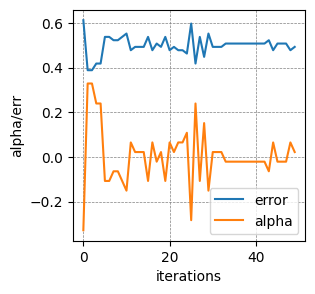

In [153]:

def print_alphas(training_alpha,training_errs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(3,3))  # Width, Height in inches
    # Adding labels
    plt.xlabel('iterations')
    plt.ylabel('alpha/err')
    plt.plot(training_errs,label="error")
    plt.plot(training_alpha,label="alpha")
    _ = plt.legend(loc='lower right')
    plt.grid(color='grey', linestyle='--', linewidth=.5)
    # Displaying the plot
    plt.show()
print(training_errs)
print(training_alpha)
print_alphas(training_alpha,training_errs)